# Conditional Routing in LangGraph

## Learning Objectives
By the end of this notebook, you will be able to:
1. **Understand conditional edges** - Learn how to create dynamic routing based on state
2. **Create routing functions** - Build logic that decides which path to take
3. **Implement decision nodes** - Create graphs that branch based on conditions
4. **Design multi-branch workflows** - Handle complex routing with many possible paths

## Why Conditional Routing?
In real-world AI applications, you need **dynamic decision-making**:
- Route to different handlers based on user intent
- Choose between tool use vs. direct response
- Handle errors gracefully with fallback paths
- Implement retry logic and loops

## Types of Edges in LangGraph

| Edge Type | Description | Syntax |
|-----------|-------------|--------|
| **Normal Edge** | Always follows this path | `add_edge(A, B)` |
| **Conditional Edge** | Chooses path based on logic | `add_conditional_edges(A, routing_fn, [...])` |

In LangGraph, conditional routing allows the dynamic determination of the next node(s) to execute based on the current state.

This is achieved using conditional edges, which evaluate a function using certain defined logic, to decide the subsequent path in the graph.

This mechanism enables the creation of adaptable workflows that respond to varying conditions during execution. Let's dive deep into conditional routing in this demo.

![](https://i.imgur.com/uX12AyO.png)

## Install Dependencies

In [1]:
!pip install -qq langchain==0.3.14
!pip install -qq langgraph==0.2.66

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-openai 1.1.6 requires langchain-core<2.0.0,>=1.2.2, but you have langchain-core 0.3.63 which is incompatible.
langgraph-prebuilt 1.0.5 requires langchain-core>=1.0.0, but you have langchain-core 0.3.63 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langgraph-prebuilt 1.0.5 requires langchain-core>=1.0.0, but you have langchain-core 0.3.63 which is incompatible.


## Part 1: Creating the Graph with Conditional Edges

### Understanding Conditional Edges

[Edges](https://langchain-ai.github.io/langgraph/concepts/low_level/#edges) connect the nodes.

- **Normal Edges** - Used when you *always* want to go from node A to node B
- **[Conditional Edges](https://langchain-ai.github.io/langgraph/reference/graphs/?h=conditional+edge#langgraph.graph.StateGraph.add_conditional_edges)** - Used when you want to *dynamically choose* the next node

### How Conditional Edges Work

1. After a node completes, the **routing function** is called
2. The routing function examines the **current state**
3. It returns a **string** matching the name of the next node
4. The graph **executes that node** next

```
                    ┌─────────────┐
                    │ weather_node│
                    └──────┬──────┘
                           │
                   ┌───────▼───────┐
                   │ routing_func  │
                   │ (evaluates    │
                   │  state)       │
                   └───────┬───────┘
                           │
              ┌────────────┼────────────┐
              │            │            │
              ▼            ▼            ▼
         ┌────────┐   ┌────────┐   ┌────────┐
         │ rainy  │   │ sunny  │   │ cloudy │
         └────────┘   └────────┘   └────────┘
```

### Syntax for Conditional Edges
```python
builder.add_conditional_edges(
    source_node,      # Node to route FROM
    routing_function, # Function that returns next node name
    [list_of_possible_nodes]  # All possible destination nodes
)
```

![](https://i.imgur.com/uX12AyO.png)

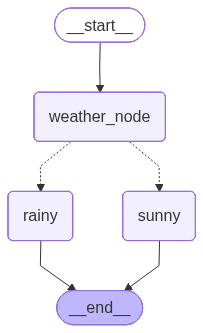

In [2]:
# ============================================================================
# BUILDING A GRAPH WITH CONDITIONAL ROUTING
# ============================================================================
# This example creates a weather-based routing system:
# - Check the weather
# - Route to different nodes based on weather condition

from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# -----------------------------------------------------------------------------
# STEP 1: Define the State
# The state contains the data used for routing decisions
# -----------------------------------------------------------------------------
class State(TypedDict):
    """
    State containing weather information.
    The 'weather' field will be used to determine routing.
    """
    weather: str

# -----------------------------------------------------------------------------
# STEP 2: Define Node Functions
# Each node handles a specific case in our workflow
# -----------------------------------------------------------------------------
def weather_node(state: State) -> State:
    """
    Initial node that processes the weather check.
    This is the "decision point" - after this, routing happens.
    """
    print(f"Checking the weather... Current condition: {state['weather']}")
    return state  # Pass state unchanged - routing will be based on it

def rainy_node(state: State) -> State:
    """Handler for rainy weather conditions."""
    print("It's rainy. Take an umbrella!")
    return state

def sunny_node(state: State) -> State:
    """Handler for sunny weather conditions."""
    print("It's sunny. Wear sunglasses!")
    return state

# -----------------------------------------------------------------------------
# STEP 3: Define the Routing Function (THE KEY PART!)
# This function examines the state and returns the NAME of the next node
# -----------------------------------------------------------------------------
def weather_routing(state: State) -> str:
    """
    Routing function that decides which node to visit next.
    
    Args:
        state: Current graph state containing weather info
        
    Returns:
        str: Name of the next node to execute
        
    Note: The returned string MUST match a node name exactly!
    """
    weather = state['weather']
    
    if weather == 'rainy':
        print(f"  → Routing to 'rainy' node")
        return "rainy"  # Must match the node name!
    elif weather == 'sunny':
        print(f"  → Routing to 'sunny' node")
        return "sunny"  # Must match the node name!
    else:
        raise ValueError(f"Unknown weather condition: {weather}")

# Initialize the StateGraph
graph_builder = StateGraph(State)

# -----------------------------------------------------------------------------
# STEP 4: Add all nodes to the graph
# -----------------------------------------------------------------------------
graph_builder.add_node("weather_node", weather_node)
graph_builder.add_node("rainy", rainy_node)
graph_builder.add_node("sunny", sunny_node)

# -----------------------------------------------------------------------------
# STEP 5: Define the edges (including conditional routing)
# -----------------------------------------------------------------------------
# Entry edge: START → weather_node
graph_builder.add_edge(START, "weather_node")

# Conditional edge: weather_node → (rainy OR sunny) based on routing function
graph_builder.add_conditional_edges(
    "weather_node",       # Source node (route FROM this node)
    weather_routing,      # Routing function (decides where to go)
    ["rainy", "sunny"]    # List of possible destination nodes
)

# Exit edges: both rainy and sunny → END
graph_builder.add_edge("rainy", END)
graph_builder.add_edge("sunny", END)

# Compile the graph
graph = graph_builder.compile()

# Visualize - notice the diamond shape indicating conditional routing
print("Conditional Routing Graph:")
display(Image(graph.get_graph().draw_mermaid_png()))

In [3]:
# ============================================================================
# TEST CASE 1: Rainy Weather
# ============================================================================
# When weather is 'rainy', the routing function should direct to rainy_node

print("=" * 60)
print("TEST CASE 1: Rainy Weather")
print("=" * 60)

initial_state_rainy = {"weather": "rainy"}
print(f"Input state: {initial_state_rainy}")
print("-" * 40)

result_rainy = graph.invoke(initial_state_rainy)

print("-" * 40)
print(f"Graph completed! Route taken: weather_node → rainy → END")


--- Rainy Condition ---
Checking the weather...
It's rainy. Take an umbrella!


In [4]:
# ============================================================================
# TEST CASE 2: Sunny Weather
# ============================================================================
# When weather is 'sunny', the routing function should direct to sunny_node

print("=" * 60)
print("TEST CASE 2: Sunny Weather")
print("=" * 60)

initial_state_sunny = {"weather": "sunny"}
print(f"Input state: {initial_state_sunny}")
print("-" * 40)

result_sunny = graph.invoke(initial_state_sunny)

print("-" * 40)
print(f"Graph completed! Route taken: weather_node → sunny → END")


--- Sunny Condition ---
Checking the weather...
It's sunny. Wear sunglasses!


In [5]:
# ============================================================================
# TEST CASE 3: Unknown Weather (Error Handling)
# ============================================================================
# What happens when we provide an unhandled weather condition?
# Our routing function should raise an error for unknown conditions

print("=" * 60)
print("TEST CASE 3: Unknown Weather (humid)")
print("=" * 60)

initial_state_humid = {"weather": "humid"}
print(f"Input state: {initial_state_humid}")
print("-" * 40)

try:
    result_humid = graph.invoke(initial_state_humid)
except ValueError as e:
    print(f"Error caught: {e}")
    print("\nThis demonstrates the importance of handling all possible cases!")
    print("In production, you might want a 'default' or 'fallback' node.")


--- Sunny Condition ---
Checking the weather...


: 

---

## Part 2: Conditional Routing with Multiple Branches

### Scaling Up: More Complex Routing

The more nodes you have, the more powerful your routing becomes! You just need to:
1. Define node functions for each case
2. Add conditions to your routing function
3. List all possible destinations in `add_conditional_edges`

### Example: Comic Book Router
Let's build a more complex example - a comic book recommendation system that:
- Identifies the topic from user input
- Routes to different handlers based on the comic universe (DC, Marvel, or Others)

```
                    ┌─────────────┐
                    │  get_topic  │
                    └──────┬──────┘
                           │
                   ┌───────▼───────┐
                   │ decide_route  │
                   └───────┬───────┘
              ┌────────────┼────────────┐
              │            │            │
              ▼            ▼            ▼
         ┌────────┐   ┌────────┐   ┌────────┐
         │ node_dc│   │ marvel │   │ others │
         └────────┘   └────────┘   └────────┘
```

![](https://i.imgur.com/uvZeLV3.png)

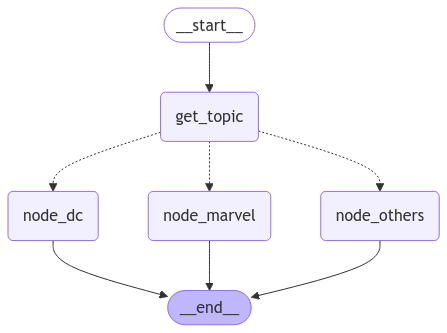

In [ ]:
# ============================================================================
# MULTI-BRANCH CONDITIONAL ROUTING: Comic Book Router
# ============================================================================

from typing import Annotated
from langgraph.graph.message import add_messages

# -----------------------------------------------------------------------------
# STEP 1: Define State with multiple fields
# Using add_messages reducer to preserve conversation history
# -----------------------------------------------------------------------------
class State(TypedDict):
    """
    State for the comic book router.
    
    Attributes:
        messages: Conversation history (using add_messages reducer)
        topic: Extracted topic for routing decisions
    """
    messages: Annotated[list, add_messages]
    topic: str

# -----------------------------------------------------------------------------
# STEP 2: Define Nodes
# -----------------------------------------------------------------------------
def get_topic(state: State) -> dict:
    """
    Extracts the topic from the first message.
    This topic will be used for routing decisions.
    """
    # Get the first message content
    first_message = state['messages'][0]
    topic = first_message.content if hasattr(first_message, 'content') else first_message
    print(f"---Extracting topic: '{topic}'---")
    return {"topic": topic}

def node_dc(state):
    """Handler for DC Comics characters (Batman, Superman, etc.)"""
    print("---Node DC Comics---")
    topic = state['topic']
    return {"messages": f"Welcome to DC Comics! We have great content about: {topic}"}

def node_marvel(state):
    """Handler for Marvel Comics characters (Spider-Man, Avengers, etc.)"""
    print("---Node Marvel Comics---")
    topic = state['topic']
    return {"messages": f"Welcome to Marvel! Here's info about: {topic}"}

def node_others(state):
    """Fallback handler for unknown/other topics"""
    print("---Node Others (Fallback)---")
    topic = state['topic']
    return {"messages": f"Sorry, we don't have comics about: {topic}. Try Batman or Spider-Man!"}

# -----------------------------------------------------------------------------
# STEP 3: Define Routing Function with Multiple Branches
# -----------------------------------------------------------------------------
def decide_route(state: State) -> str:
    """
    Multi-branch routing function.
    
    Examines the topic and routes to appropriate handler:
    - DC characters → node_dc
    - Marvel characters → node_marvel
    - Unknown → node_others (fallback)
    """
    print("---Conditional Routing Decision---")
    topic = state['topic'].lower()
    print(f"  Topic: '{topic}'")
    
    # Define our routing rules
    DC_CHARACTERS = ['batman', 'superman', 'wonder woman', 'flash', 'aquaman']
    MARVEL_CHARACTERS = ['spiderman', 'spider-man', 'avengers', 'iron man', 'thor', 'hulk']
    
    if topic in DC_CHARACTERS:
        print(f"  → Routing to DC Comics")
        return "node_dc"
    elif topic in MARVEL_CHARACTERS:
        print(f"  → Routing to Marvel Comics")
        return "node_marvel"
    else:
        print(f"  → Routing to Others (fallback)")
        return "node_others"

# -----------------------------------------------------------------------------
# STEP 4: Build the Graph
# -----------------------------------------------------------------------------
builder = StateGraph(State)

# Add all nodes
builder.add_node("get_topic", get_topic)
builder.add_node("node_dc", node_dc)
builder.add_node("node_marvel", node_marvel)
builder.add_node("node_others", node_others)

# Define edges
builder.add_edge(START, "get_topic")

# Conditional edge with THREE possible destinations
builder.add_conditional_edges(
    "get_topic",
    decide_route,
    ["node_dc", "node_marvel", "node_others"]  # All possible destinations
)

# All branches lead to END
builder.add_edge("node_dc", END)
builder.add_edge("node_marvel", END)
builder.add_edge("node_others", END)

# Compile
graph = builder.compile()

# Visualize
print("Multi-Branch Routing Graph:")
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# ============================================================================
# HELPER FUNCTION FOR TESTING
# ============================================================================

def call_agent(agent, topic):
    """
    Helper function to test the comic router agent.
    
    Args:
        agent: The compiled graph
        topic: The topic to search for
    
    Prints the final response from the agent.
    """
    print("=" * 50)
    print(f"User Query: '{topic}'")
    print("=" * 50)
    
    # Invoke the agent with the topic as a message
    result = agent.invoke({"messages": topic})
    
    # Extract and print the final response
    final_message = result['messages'][-1]
    response = final_message.content if hasattr(final_message, 'content') else final_message
    
    print("-" * 50)
    print(f"Agent Response: {response}")
    print("=" * 50)
    print()


In [ ]:
# ============================================================================
# TEST: DC Comics Character (Batman)
# Expected: Routes to node_dc
# ============================================================================
call_agent(graph, "Batman")

---Getting topic: Batman---
---Conditional Routing---
Batman
---Node DC Comics---
Hello yes happy to show you comics of: Batman


In [ ]:
# ============================================================================
# TEST: Marvel Comics Character (Avengers)
# Expected: Routes to node_marvel
# ============================================================================
call_agent(graph, "avengers")

---Getting topic: avengers---
---Conditional Routing---
avengers
---Node Marvel Comics---
Hello yes happy to show you comics of: avengers


In [ ]:
# ============================================================================
# TEST: Unknown Character (Venom - not in our list)
# Expected: Routes to node_others (fallback)
# ============================================================================
call_agent(graph, "Venom")

---Getting topic: Venom---
---Conditional Routing---
Venom
---Node Others---
Sorry we do not have: Venom


---

## Summary: Key Takeaways

### What We Learned

1. **Conditional edges enable dynamic routing** - Choose the next node based on state
2. **Routing functions are simple** - Just return the name of the next node
3. **Always include a fallback** - Handle unknown cases gracefully
4. **Multiple branches are easy** - Just add more conditions and nodes

### Conditional Edge Syntax Recap

```python
builder.add_conditional_edges(
    source_node,         # Node to route FROM
    routing_function,    # Returns string: next node name
    [possible_nodes]     # List of all possible destinations
)
```

### Best Practices

| Practice | Description |
|----------|-------------|
| **Clear routing logic** | Keep conditions simple and readable |
| **Fallback handling** | Always have a default/fallback case |
| **Descriptive names** | Use meaningful node names |
| **Separate concerns** | Routing logic separate from processing |

### Real-World Applications

- **Intent Classification**: Route based on user intent (question, command, feedback)
- **Tool Selection**: Choose which tool to call based on query type
- **Error Handling**: Route to error recovery nodes when issues occur
- **Multi-step Workflows**: Implement complex business logic with multiple paths

### Next Steps
In the next notebook, we'll build an **LLM-powered Chatbot** that combines these concepts with real language model integration!